# Анализ A/B-теста с целью увеличения выручки для интернет-магазина

Мы являемся аналитиком крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки. Наша задача - приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты. 

### Загрузка данных и подготовка их к анализу

Изучим данные и выполним предобработку. Проверим данные на пропуски и дубликаты. Убедимся, что типы данных во всех колонках соответствуют сохранённым в них значениям. 

#### Импортируем все необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as stats
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings

register_matplotlib_converters()

Изучаем данные о каждом датасете

In [3]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [7]:
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [8]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


#### Изменение типов данных

В ходе изучения общей информации о данных датасетах, мы выявили, что в некоторых столбцах типы данных не соответствуют представленным в них значениям. К таким столбцам относятся `date` из датасета orders и `date` из датасета visitors. Во всех этих столбцах предсталены данные о дате и времени, но тип данных в них object. Необходимо заменить тип данных object на datetime.

In [9]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

Проверим, что получилось. Вывыдем ещё раз общую информацию о датасетах.

In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [11]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


#### Изменение названий столбцов

Приведем названия столбцов к нижнему регистру и к snake_case

In [12]:
hypothesis.columns

Index(['Hypothesis', 'Reach', 'Impact', 'Confidence', 'Efforts'], dtype='object')

In [41]:
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts', 'ice',
       'rice'],
      dtype='object')

#### Обработка пропусков

In [14]:
orders.isna().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [15]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

В данных датафреймах нет пропусков. Переходим к следующему этапу предобработки данных.

#### Обработка дубликатов

In [16]:
orders.duplicated().sum()

0


In [17]:
visitors.duplicated().sum()

0


In [42]:
hypothesis.duplicated().sum()

0

Ни в одном датасете явные дубликаты не обнаружены

### Приоритизация гипотез

Изучим ещё раз файл с гипотезами и оценками параметров ICE. Посчитаем ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета. 

In [19]:
pd.options.display.max_colwidth = 120

In [20]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [21]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts']
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending = False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Фреймворк ICE показал, что наиболее перспективные гипотезы - 8, 0, 7, 6.

In [22]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['confidence'] * hypothesis['impact']) / hypothesis['efforts']
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


 Фремфорк RICE показал, что наиболее перспективные гипотезы - 7, 2, 0, 6. Особенно выделяется гипотеза под номером 7.  

При применении RICE приоритация гипотез измнилась, так как при ICE наиболее перспективными были гипотезы 8(Запустить акцию, дающую скидку на товар в день рождения), 0(Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей), 7(Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок), 6(Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию), а при RICE наиболее перспективными являются 7(Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок), 2(Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа), 0(Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей), 6(Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию). 

Изменился порядок приоритизации, только гипотезы 0 и 6 вошли в оба фреймворка. Так произошло, потому что при расчёте с помощью фреймворка RICE был задействован ещё один важный показатель - Reach, который показывает скольких пользователей затронет изменение, которое мы хотим внести. Такие гипотезы, как "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" и "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа" затронет большее количество пользователей, чем другие гипотезы.	

### Анализ A/B - теста

Мы провели A/B-тест и получили его результаты. Перед тем, как начать анализ, нам необходимо проверить, нет ли в таблицах пересекающихся по группам пользователей, то есть тех, кто попал в обе группы.

In [23]:
double_users = orders.groupby('visitorId').agg({'group':'nunique'}).query('group>1')
users_unique = orders['visitorId'].nunique()

print('Количество пользователей, попавших одновременно в обе группы: {}\n'
      'Количество уникальных пользователей, принявших участие в тесте: {}\n'
      'Процент пользователей, попавших одновременно в обе группы: {:.2%}'.format(len(double_users),
                                                                                users_unique,
                                                                                len(double_users)/users_unique))

Количество пользователей, попавших одновременно в обе группы: 58
Количество уникальных пользователей, принявших участие в тесте: 1031
Процент пользователей, попавших одновременно в обе группы: 5.63%


Мы выявили, что в результатах теста насчитывается 58 пользователей (что составляет 5.63%), которые попали в обе группы, и 1031 уникальный пользователь. Удалим пользователей, которые попали в обе группы, чтобы в дальнейшем это не исказило анализ результатов A/B-теста.

In [24]:
orders.groupby('visitorId').agg({'group' : 'nunique'}).query('group>1').count()
double_users = orders.groupby('visitorId').agg({'group' : 'nunique'}).reset_index().query('group>1')['visitorId'].unique()
orders = orders.query('visitorId not in @double_users')

Проверим количество пользователей, которые попали в обе группы, после удаления

In [25]:
double_users_check = orders.groupby('visitorId').agg({'group':'nunique'}).query('group>1')
print('Количество пользователей, попавших одновременно в обе группы:', len(double_users_check))

Количество пользователей, попавших одновременно в обе группы: 0


#### График кумулятивный выручки по группам

Создадим переменные, необходимые для построения графика кумулятивной выручки по группам.

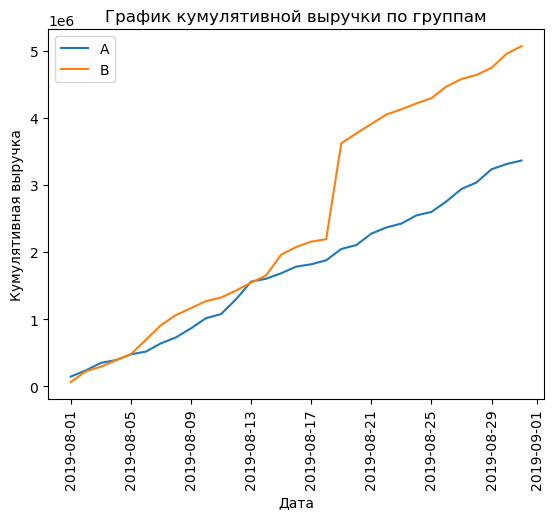

In [45]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])


visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])


cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]


cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue','orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue','orders']]


plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')


plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend() 
plt.xticks(rotation=90)
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')

plt.show()

По графику мы видим, что сначала результаты группы A и B были одинаковыми, потом с 17 по 21 августа произошёл резкий скачок и группа B вырвалась вперёд, возможно, это связано с аномально большими заказами, после чего группа B продолжила показывать более высокие результаты, чем группа A.

#### График кумулятивного среднего чека по группам

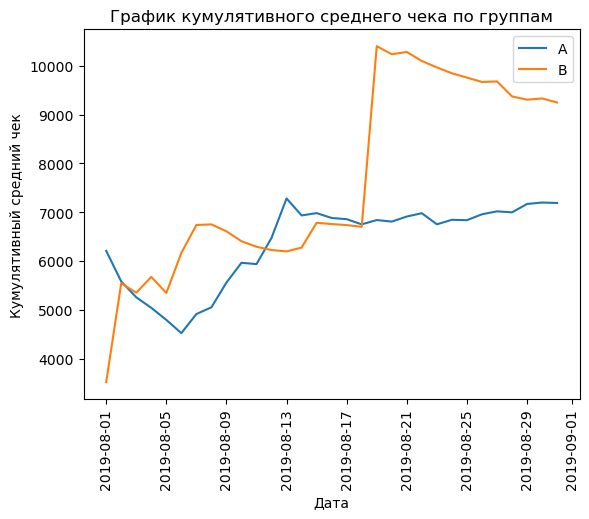

In [27]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 
plt.xticks(rotation=90)
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')

plt.show()

Кумулятивное значение среднего чека довольно сильно колеблется в обеих группах. Резкий скачок наблюдается 21 августа в группе B, это связано с аномально дорогим заказом. Делать выводы по этому графику рано, сначала необходим дополнительный анализ выбросов.

#### График относительного изменения кумулятивного среднего чека группы B к группе A

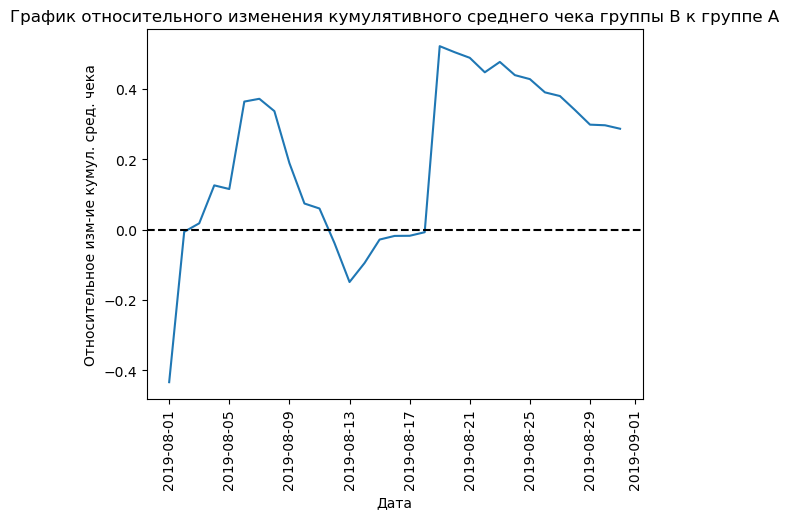

In [28]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--') 
plt.xticks(rotation=90)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изм-ие кумул. сред. чека')

plt.show()

Группа B в основном лучше группы A по кумулятивному среднему чеку. Однако этот показатель не стабилен, на графике мы видим, что кумулятивный средний чек группы B относительно группы A резко увеличивается, а затем резко начинает снижаться. Это также может быть связано с выбросами.

#### График кумулятивного среднего количества заказов на посетителя по группам

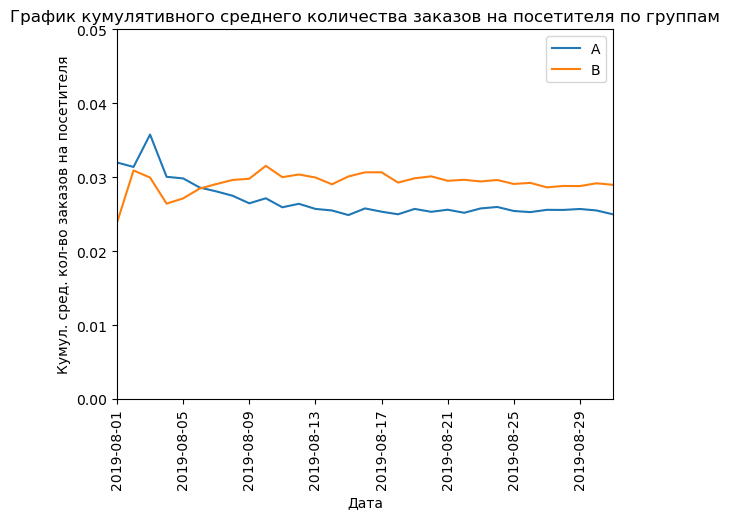

In [29]:
cumulativeData['ratio'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
plt.plot(cumulativeDataA['date'], cumulativeDataA['ratio'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['ratio'], label='B')
plt.legend()
plt.axis([dt.datetime.strptime("2019-08-01", '%Y-%m-%d'), dt.datetime.strptime("2019-08-31", '%Y-%m-%d'), 0, 0.05])
plt.xticks(rotation=90)
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Кумул. сред. кол-во заказов на посетителя')

plt.show()

В начале теста группа A показала лучший результат, чем группа B. Затем сегмент B начал увеличиваться и приобрел довольно высокий и стабильный результат, при этом показатель группы A упал и держится на довольно низком уровне относительно группы B.

#### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


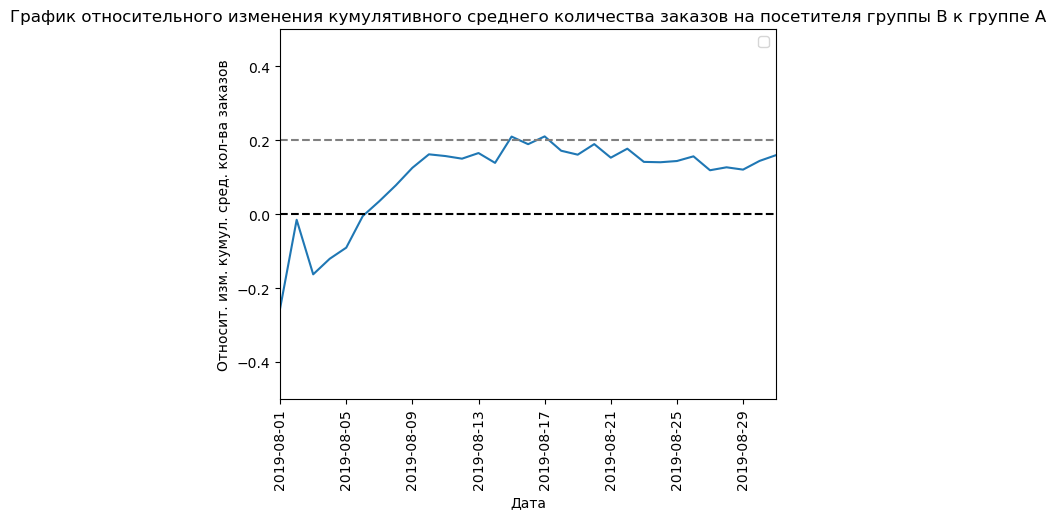

In [30]:
mergedCumulativeRatio = cumulativeDataA[['date','ratio']].merge(cumulativeDataB[['date','ratio']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeRatio['date'], mergedCumulativeRatio['ratioB']/mergedCumulativeRatio['ratioA']-1)
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.5, 0.5])

plt.xticks(rotation=90)
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относит. изм. кумул. сред. кол-ва заказов')

plt.show()

Группа B стабильно лучше группы A по кумулятивному среднему количеству заказов на посетителя. Показатель зафиксировался на уровне 15-20%.

#### Точечный график количества заказов по пользователям

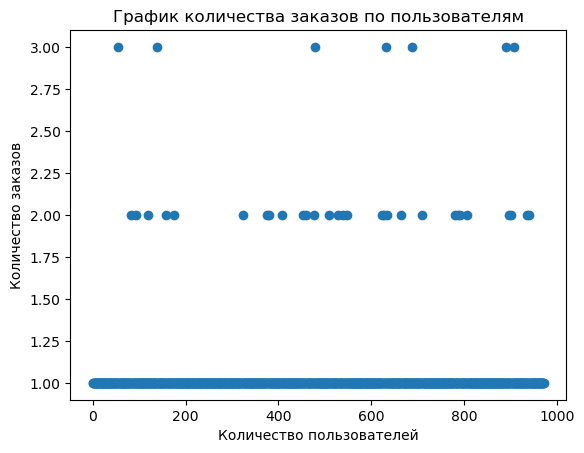

In [31]:
ordersByUsers = (orders.groupby('visitorId', as_index=False).agg({'transactionId':'nunique'}))
ordersByUsers.columns = ['userId', 'orders']
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])

plt.title('График количества заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов')

plt.show()

На графике мы видим, что большинство пользователей сделали 1-2 заказа. Только несколько пользователей сделали более 2 заказов.

#### Расчёт 95-ого и 99-ого перцентилей количества заказов на пользователя.

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [49]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 2.]


Не более 5% пользователей оформляли более одного заказа, и не более 1% пользователей оформляли больше 2 заказов. На наш взгляд, оптимально будет отсеять аномальных пользователей, которые сделали более 2 заказов.

#### Точечный график стоимостей заказов

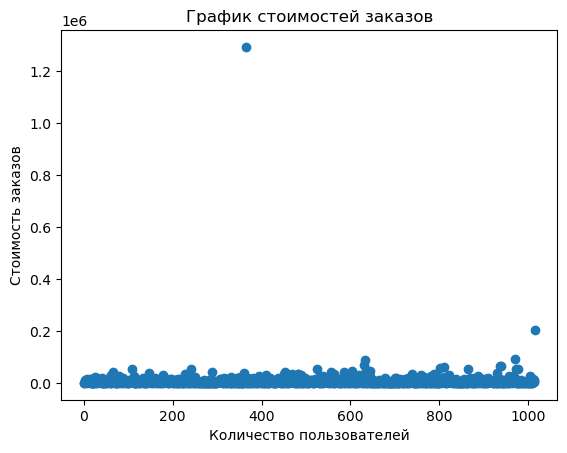

In [33]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 

plt.title('График стоимостей заказов')
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказов')

plt.show()

Основная часть заказов имеет стоимость до 100000 рублей. Есть несколько аномально дорогих заказов, но их немного.

#### Расчёт 95-ого и 99-ого перцентилей стоимости заказов

Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [48]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


Не более 5% заказов имеют стоимость более 27000 рублей и не более 1% заказов стоят более 54000 рублей. На наш взгляд, оптимально будет отсеять аномальные заказы, стоимостью более 54000 рублей.

#### Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Подготовим данные для расчёта статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Выведем первые 5 строк, получившейся таблицы.
Проверим нулевую гипотезу, которая звучит, как: "Различий в среднем количестве заказов между группами A и B нет"(по сырым данным). Альтернативная гипотеза: различия в среднем количестве заказов на посетителя между группами есть. 

In [50]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


In [36]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders'] 


pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(
              0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), 
              name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(
              0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), 
              name='orders')],axis=0)

print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("{0:.3f}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1))

0.01102
0.160


P-value 0.01, это значительно меньше 0.05,следовательно нулевую гипотезу необходимо отвергнуть. Анализ "сырых данных" показал, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы B к среднему группы A составляет 16%.

#### Расчёт статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

Теперь проверим нулевую гипотезу, которая звучит так: "Различий в среднем чеке заказа между группами A и B нет"(по сырым данным). Альтернативная гипотеза: различия в среднем чеке между группами есть. 

In [37]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                          orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].
                       mean()/orders[orders['group']=='A']
                       ['revenue'].mean()-1)) 

0.829
0.287


P-value составляет 0.8, это значительно больше 0.05, следовательно мы не отвергаем нулевую гипотезу, то есть различий между средним чеком заказа нет. Однако относительное различие среднего чека между группами очень большое, оно составляет 28%. Скорее всего, это связано с несколькими аномально дорогими заказами, которые мы вычислили с помощью 99-ого перцинтиля.

####  Расчёт статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

In [51]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 54000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormalUsers.head()
abnormalUsers.shape[0]

16

Всего 16 аномальных пользователей. Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста

In [52]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.007
0.189


P-value в "очищенных данных" составляет 0.007, что значительно меньше 0.05, следовательно, как и в "сырых данных" мы отвергаем нулевую гипотезу, то есть в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы B к среднему группы A в "очищенных данных" составляет 19%.

#### Расчёт статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

In [40]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()- 1
    )
)

0.788
-0.032


P-value в "очищенных данных" почти не изменилось, было 0.8, стало 0.78. Относительное различие среднего чека между группами значительно сократилось, оно составляло 28% в пользу группы B, сейчас оно составляет 3% в пользу группы A. Это значит, что аномалии очень сильно повлияли на резултат относительного различия среднего чека между сегментами.

### Общий вывод

В данном проекте мы работали с результатами A/B-теста с целью увеличения выручки для крупного интернет-магазина. Наша задача заключалась в приоритизации гипотез и анализе результатов A/B-теста.

На этапе предобработки мы подготовили данные для анализа, а именно изменили типы данных в тех столбцах, где типы данных не соответствовали представленным в них значениям, привели названия столбцов к нижнему регистру, проверили данные на наличие пропусков и дубликатов.

После этого мы приоритизирвали гипотезы с помощью фреймворков ICE и RICE. При применении RICE приоритация гипотез изменилась, так как при ICE наиболее перспективными были гипотезы 8,0,7,6, а при RICE наиболее перспективными являются 7, 2, 0, 6. Изменился порядок приоритизации, только гипотезы 0 и 6 вошли в оба фреймворка. Так произошло, потому что при расчёте с помощью фреймворка RICE был задействован ещё один важный показатель - Reach, который показывает, скольких пользователей затронет изменение, которое мы хотим внести. 

Перед тем, как начать анализ A/B-теста мы выявили, что в результатах теста насчитывается 58 пользователей (что составляет 5.63%), которые попали в обе группы, и 1031 уникальный пользователь. Мы удалили пользователей, которые попали в обе группы, чтобы в дальнейшем это не исказило анализ результатов A/B-теста.

Далее мы провели анализ результатов A/B-теста и пришли к следующим выводам:

1. На графике кумулятивной выручки мы выявили, что в основном группа B показывала более высокие результаты, чем группа A.


2. Кумулятивное значение среднего чека довольно сильно колеблется в обеих группах. Возможно, это связано с аномально дорогими заказами. Делать выводы по этому графику рано, сначала необходим дополнительный анализ выбросов.


3. График относительного изменения кумулятивного среднего чека группы B к группе A показал, что Группа B в основном лучше группы A.Однако этот показатель не стабилен, на графике мы видим, что кумулятивный средний чек группы B относительно группы A резко увеличивается, а затем резко начинает снижаться. Это также может быть связано с выбросами.


4. График кумулятивного среднего количества заказов на посетителя по группам показал, что сегмент B постепенно приобрел довольно высокий и стабильный результат, при этом показатель группы A упал и держится на довольно низком уровне относительно группы B.


5. График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A показал, что группа B стабильно лучше группы A по кумулятивному среднему количеству заказов на посетителя. Показатель зафиксировался на уровне 15-20%.


6. С помощью точечных графиков и расчёта перцентилей мы выявили, что не более 5% пользователей оформляли более одного заказа, и не более 1% пользователей оформляли больше 2 заказов. На наш взгляд, оптимально будет отсеять аномальных пользователей, которые сделали более 2 заказов. Также мы выявили, что не более 5% заказов имеют стоимость более 27000 рублей и не более 1% заказов стоят более 54000 рублей. На наш взгляд, оптимально будет отсеять аномальные заказы, стоимостью более 54000 рублей.


7. Расчёт статистической значимости различий в среднем количестве заказов на посетителя между группами по "сырым" и "очищенным" данным показал похожие результаты. P-value оказалось значительно меньше 0.05 (0.01 и 0.007 соответсвенно), что позволило нам отвергуть нулевую гипотезу, то есть в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы B к среднему группы A в "очищенных" данных составил 19%.


8. В расчёте статистической значимости различий в среднем чеке заказа между группами по «сырым» и "очищенным" данным были выявлены некие различия. P-value в "очищенных данных" почти не изменилось, было 0.8, стало 0.78, таким образом, мы не отвергли нулевую гипотезу, то есть различий между средним чеком заказа нет. Относительное различие среднего чека между группами значительно сократилось, оно составляло 28% в пользу группы B, сейчас оно составляет 3% в пользу группы A. Это значит, что аномалии очень сильно повлияли на результат относительного различия среднего чека между сегментами.

По итогам исследования мы приняли решение об остановке A/B-теста. На графиках мы увидели, что группа B превзошла группу A по многим показателям.
Мы приняли решение об остановке теста с победой группы B. Тест идёт уже месяц и собранных данных достаточно для формирования стратегии по увеличению выручки. 

Таким образом, мы рекомендуем добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок и добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей. Эти два решения помогут увеличить прибыль компании.